In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import torch
import time

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
device = torch.device("cpu")

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [5]:
from torch.nn import functional as F

In [6]:

import torch
device = torch.device(device)

In [7]:
batch_size = 128
epochs = 100
num_resnet_blocks = 16
num_scales = 2
num_step_of_flow = 2 # 3 * 6 affine layers
sample_path = "./bs_samples"#f"./plots_{num_scales}_scale_{num_step_of_flow * 6}_affines_resnet_{num_resnet_blocks}"

In [6]:
! mkdir -f {sample_path}

mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.


In [7]:
# celebA_train_dataset = torchvision.datasets.CelebA(root="/home/ext_amin_unity3d_com/real_nvp_data_celebA",
#                                                    split="train",
#                                                    download=True,
#                                                    transform=transforms.Compose([transforms.ToTensor()])
#                                                    )

In [8]:
# celebA_train_dataloader = torch.utils.data.DataLoader(celebA_train_dataset, batch_size=64)

In [9]:
lsun_train_dataset = ImageDataset(root_dir="/home/ext_amin_unity3d_com/real_nvp_data/train")
lsun_train_dataloader = init_dataloader(lsun_train_dataset, batch_size=batch_size)

In [10]:
dataset = lsun_train_dataset
dataloader = lsun_train_dataloader

In [8]:
tmp_input = torch.rand(5, 3, 32, 32).to(device)
tmp_input_split = torch.ones(5, 6, 16, 16).to(device)

In [9]:
from utils import Scale
scale = Scale(mask_orientation=0).to(device=device)
forwarded_scale, tmp_log_det  = scale(tmp_input)
reversed_scale = scale.reverse(forwarded_scale)
print(torch.norm(tmp_input - reversed_scale))


tensor(758.7227)


In [10]:
from utils import StepOfGlow
num_resnet_blocks = 8
sog = StepOfGlow(base_input_shape=[3, 32, 32],
                 num_resnet_blocks=num_resnet_blocks).to(device=device)
forwared, logdet = sog(tmp_input)
reversed = sog.reverse(forwared)
torch.linalg.norm(tmp_input - reversed)

tensor(2.8245e-06, grad_fn=<LinalgVectorNormBackward0>)

In [11]:
from blocks import GlowBlock
gb = GlowBlock(K=2,
               base_input_shape=[3, 32, 32],
               num_resnetblock=8).to(device=device)

forwared, logdet, split = gb(tmp_input)
reversed = gb.reverse(z_i=split, z_l=forwared)
torch.linalg.norm(tmp_input - reversed)

tensor(3.0258e-05, grad_fn=<LinalgVectorNormBackward0>)

In [60]:
from models import Glow
glow = Glow(K=2,L=2,base_input_shape=[3, 64, 64], num_resnet_blocks=8).to(device=device)
z_samples = torch.distributions.Normal(0, 1).\
sample(sample_shape=([25] + glow.final_step_of_flow[-1].base_input_shape))
forwared = glow(tmp_input)
glow.sample(device=device, num_samples=25).shape

torch.Size([5, 12, 8, 8]) torch.Size([5, 12, 8, 8])
torch.Size([5, 6, 16, 16]) torch.Size([5, 6, 16, 16])


AttributeError: module 'torch' has no attribute 'assert_close'

In [52]:
tmp_input.shape

AttributeError: 'torch.Size' object has no attribute 'numpy'

In [13]:
final_scale = FinalScale().to(device)
forwarded_fs, _ = final_scale(tmp_input_split)
reversed_fs = final_scale.reverse(forwarded_fs)
print(torch.norm(tmp_input_split - reversed_fs))

tensor(0.0028, device='cuda:1')


In [14]:
realnvp = RealNVP(num_scales=num_scales,
                  num_step_of_flow=num_step_of_flow,
                  num_resnet_blocks=num_resnet_blocks).to(device)

In [15]:
z_samples = torch.distributions.Normal(0, 1).sample(sample_shape=([25] + realnvp.final_scale.base_input_shape))
realnvp.sample(z_base_sample=z_samples)

tensor([[[[-6.7813e+05,  8.9277e+07, -9.7800e+06,  ..., -2.0831e+07,
            8.1259e+06, -5.1307e+06],
          [ 1.0568e+08,  2.6953e+08, -1.5340e+08,  ..., -1.3975e+07,
            8.0875e+05, -7.9103e+06],
          [ 1.2972e+08,  4.8134e+07,  1.6926e+07,  ...,  1.4176e+06,
            3.3249e+06, -1.7071e+06],
          ...,
          [ 7.6660e+06, -1.4288e+07, -3.5109e+08,  ...,  1.8148e+07,
            9.2358e+07, -2.1087e+08],
          [ 5.5042e+07,  1.0592e+08,  8.0215e+06,  ...,  3.3598e+07,
           -4.5550e+07,  1.0018e+08],
          [ 4.3371e+06,  9.5335e+06,  7.6471e+07,  ...,  1.8575e+07,
            2.6498e+07,  3.6078e+06]],

         [[ 5.7802e+07, -7.8399e+06, -3.1689e+06,  ..., -4.2759e+07,
           -5.5561e+07, -1.2844e+07],
          [ 1.5452e+07,  6.7754e+06, -2.2489e+07,  ..., -1.2033e+06,
            1.0841e+08,  1.7441e+06],
          [ 3.1334e+07, -6.9085e+06,  8.0021e+07,  ...,  2.3641e+07,
           -1.0032e+08, -2.3631e+08],
          ...,
     

In [218]:
realnvp = RealNVP(num_scales=num_scales, device=device,
                  num_step_of_flow=num_step_of_flow,
                  num_resnet_blocks=num_resnet_blocks).to(device)
print(f"number of parameters in the model {sum([p.numel() for p in realnvp.parameters()])}")
optimizer = torch.optim.Adam(lr=1e-3, params=realnvp.parameters())

number of parameters in the model 884972


torch.Size([5, 5, 3, 32, 32])


FileNotFoundError: [Errno 2] No such file or directory: './tmp/sample/fixed_generated_image_epoch_1000.png'

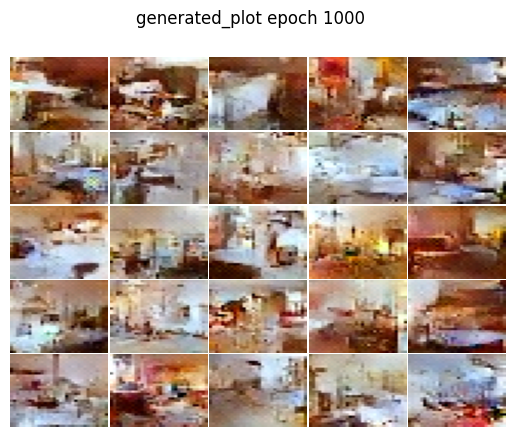

In [224]:
n_row, n_column = 5, 5
n_channels, h, w = realnvp.final_scale.base_input_shape
z_base_sample_shape = [n_row * n_column, n_channels, h, w]
z_base_sample = torch.distributions.Normal(0, 1).sample(sample_shape=z_base_sample_shape)
generated_image_fixed = realnvp.sample(n_row * n_column, z_base_sample=z_base_sample).view(n_row, n_column, 3, 32, 32)
print(generated_image_fixed.shape)
save_plot(n_row=5, n_column=5, generated_image=generated_image_fixed, fixed_image=True, path="./tmp/sample", epoch=1000)

In [20]:
# plotting
n_row, n_column = 5, 5
n_channels, h, w = realnvp.final_scale.base_input_shape
z_base_sample_shape = [n_row * n_column, n_channels, h, w]
z_base_sample = torch.distributions.Normal(0, 1).sample(sample_shape=z_base_sample_shape)

loss_per_epoch = []
for e in range(0, epochs):
    loss_per_bath = []
    epoch_start_time = time.time()
    for i, data in enumerate(dataloader):
        image_batch = data.to(device)
        optimizer.zero_grad()
        z, loss = realnvp(image_batch)
        loss.backward()
        optimizer.step()
        if i % 99 == 0:
            print(f"epcoh {e}, batch {i}, loss {loss}")
        loss_per_bath.append(loss)
    
    epoch_loss = torch.Tensor(loss_per_bath).mean()
    epoch_end_time = time.time()
    print(f"epoch {e}, took: {epoch_end_time - epoch_start_time} loss: {epoch_loss}")
    realnvp.eval()
    
    
    generated_image = realnvp.sample(n_row * n_column, z_base_sample=None).view(n_row, n_column, 3, 32, 32)
    save_plot(n_row=n_row, n_column=n_column, path=sample_path, generated_image=generated_image, epoch=e, fixed_image=False)
    
    generated_image_fixed = realnvp.sample(n_row * n_column, z_base_sample=z_base_sample).view(n_row, n_column, 3, 32, 32)
    save_plot(n_row=n_row, n_column=n_column, path=sample_path, generated_image=generated_image_fixed, epoch=e, fixed_image=True)
    
    realnvp.train()
    
    loss_per_epoch.append(epoch_loss)

epcoh 0, batch 0, loss 24.686450958251953
epcoh 0, batch 99, loss 20.845592498779297
epcoh 0, batch 198, loss 20.163156509399414
epcoh 0, batch 297, loss 19.719894409179688
epcoh 0, batch 396, loss 19.411968231201172
epoch 0, took: 922.2695274353027 loss: 20.220735549926758


AttributeError: 'NoneType' object has no attribute 'to'

In [135]:
from utils import create_deterministic_sample

In [152]:
fixed = create_deterministic_sample(sampling_params=SimpleNamespace(num_samples_nrow=1, num_samples_ncols=1), input_shape=[1, 1, 1])

print(fixed)
print(torch.distributions.Normal(0, 1).sample())

tensor([[[[0.3367]]]])
tensor(0.1288)


In [219]:
checkpoint = torch.load("./model_checkpoints/20230527_044946/best_model.pt")

In [220]:
realnvp.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [176]:
checkpoint["model_state_dict"]["flow_blocks.0.scales.0.batch_normalization_bijector_1.running_mean"].shape

torch.Size([1, 3, 32, 32])

In [216]:
from utils import BatchNormalizationBijector
bn_bj = BatchNormalizationBijector(input_shape=[3, 32, 32], decay=0.)
print(bn_bj.running_mean.shape)

torch.Size([1, 3, 32, 32])


In [217]:
tmp_input = torch.rand(size=[2, 3, 32, 32])
forwarded, _ = bn_bj(tmp_input)
backwarded = bn_bj.reverse(forwarded)

torch.linalg.norm(tmp_input - backwarded)

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])


tensor(2.6112e-07)

In [213]:
bn_bj.running_mean.shape

torch.Size([1, 3, 32, 32])

In [184]:
torch.save({'model_state_dict': bn_bj.state_dict()}, "test.pt")

In [190]:
torch.load("test.pt")["model_state_dict"]["running_mean"].shape

torch.Size([3, 32, 32])

In [ ]:

class ActNorm(tfp.bijectors.Bijector):
    def __init__(self, name=None) -> None:
        self.initialized = False
        super().__init__(name, forward_min_event_ndims=0)
    
    def initialize_bijectors(self, z):
        """initializes the Shift and Scale Bijectors based on z

        Args:
            z (_type_): batch of data of shape [bs, h, w, ch]
        """
        batch_mean = tf.reduce_mean(z, axis=[0, 1, 2])
        batch_variance = tf.reduce_mean((z - batch_mean)**2, axis=[0, 1, 2])
        
        self._shift_bijector = tfp.bijectors.Shift(shift=tf.Variable(-batch_mean))
        self._scale_bijector = tfp.bijectors.Scale(scale=tf.Variable(1/tf.sqrt(batch_variance)))
        
        self.act_norm_bijector = tfp.bijectors.Chain([self._scale_bijector, self._shift_bijector])
    
    def _forward(self, z):
        if self.initialized is False:
            self.initialize_bijectors(z)
            self.initialized = True
        
        return self.act_norm_bijector(z)
    
    def _inverse(self, x):
        assert self.initialized is True, "bijectors have not been initialized! initialize them using a batch of data and calling the forward method"
        return self.act_norm_bijector.inverse(x)

    def _forward_log_det_jacobian(self, x):
        assert self.initialized is True, "bijectors have not been initialized! initialize them using a batch of data and calling the forward method"
        return self.act_norm_bijector.forward_log_det_jacobian(x)
    
                       

In [6]:
x = torch.rand(5, 3, 32, 32)
x = torch.arange(start=1, end=5 * 3 * 32 * 32+1).type(torch.float32).reshape(5, 3, 32, 32)

In [7]:
x_mean = x.mean(dim=[0, 2, 3], keepdim=True)
x_variance = variance = ((x - x_mean)**2).mean(dim=[0, 2, 3], keepdim=True) 

In [8]:
x_variance.shape

torch.Size([1, 3, 1, 1])

In [9]:
x_variance.sum()

tensor(56885244.)

In [10]:
torch.tile(x_variance.sum(), dims=[5]).shape

torch.Size([5])

In [11]:
class ActNorm(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.initialized = False

    def  initialize_layer(self, x):
        batch_mean = x.mean(dim=[0, 2, 3], keepdim=True)
        batch_variance = ((x - batch_mean)**2).mean(dim=[0, 2, 3], keepdim=True)
        
        self.batch_mean = torch.nn.Parameter(batch_mean)
        self.batch_variance = torch.nn.Parameter(batch_variance)
        self.initialized = True
    
    def forward(self, x):
        if self.initialized is False:
            self.initialize_layer(x)
        
        y = (x - self.batch_mean) / torch.sqrt(self.batch_variance)
        
        # caluclate log det
        h, w = y.shape[2:]
        log_det =  -.5 * h * w * torch.log(self.batch_variance).sum()
        # the above is logdet for one sample in the batch, we to one for each sample in the batch_size
        log_det = torch.tile(log_det, dims=[y.shape[0]])
        return y, log_det
    
    def reverse(self, z):
        assert self.initialized is True, "ActNorm needs to be initialized before calling reverse"
        x = z * torch.sqrt(self.batch_variance) + self.batch_mean
        return x

In [12]:
ac = ActNorm()
ac.initialize_layer(x)
forwarded, _ = ac(x)
backwarded = ac.reverse(forwarded)
torch.linalg.norm(x - backwarded)

tensor(0.0069, grad_fn=<LinalgVectorNormBackward0>)

In [7]:
c = 3
h, w = 2, 2
x = torch.arange(1, 5 * c * h * w + 1).reshape(5, c, h, w).type(torch.float32)

In [54]:
w = torch.Tensor([[[[0, 0, 1], [0, 1, 0], [1, 0, 0]]]]).view( 3, 3, 1, 1)
w.shape

torch.Size([3, 3, 1, 1])

In [86]:
c, h, w = 2, 2, 2
a = torch.arange(1, c * h * w + 1).reshape(c, h, w).type(torch.float32)
a, a.shape

(tensor([[[1., 2.],
          [3., 4.]],
 
         [[5., 6.],
          [7., 8.]]]),
 torch.Size([2, 2, 2]))

In [179]:
w = torch.tensor([[0, 1], [1, 0]], dtype=torch.float32)

In [180]:
y = torch.nn.functional.conv2d(input=a, weight=w.view(2, 2, 1, 1), padding="same")
y, y.shape

(tensor([[[5., 6.],
          [7., 8.]],
 
         [[1., 2.],
          [3., 4.]]]),
 torch.Size([2, 2, 2]))

In [141]:
torch.nn.functional.conv2d(input=y, weight=torch.linalg.inv(w), padding="same", groups=1)

tensor([[[17.0000, 22.0000],
         [27.0000, 32.0000]],

        [[11.5000, 15.0000],
         [18.5000, 22.0000]]])

In [154]:
q, _ = torch.qr(w)
q.shape, 
weight = q.unsqueeze(2).unsqueeze(3)
weight.shape


torch.Size([2, 2, 1, 1])

In [175]:
weight

tensor([[[[-0.7071]],

         [[-0.7071]]],


        [[[-0.7071]],

         [[ 0.7071]]]])

In [178]:
weight[1][0].shape

torch.Size([1, 1])

In [165]:
y = torch.nn.functional.conv2d(input=a, weight=weight, padding="same", groups=1)
y, y.shape

(tensor([[[-4.2426, -5.6569],
          [-7.0711, -8.4853]],
 
         [[ 2.8284,  2.8284],
          [ 2.8284,  2.8284]]]),
 torch.Size([2, 2, 2]))

In [166]:
inv_weight = weight.squeeze().inverse().unsqueeze(2).unsqueeze(3) 
torch.nn.functional.conv2d(input=y, weight=inv_weight, padding="same", groups=1)

tensor([[[1.0000, 2.0000],
         [3.0000, 4.0000]],

        [[5.0000, 6.0000],
         [7.0000, 8.0000]]])

In [168]:
weight.inverse()

tensor([[[[-1.4142]],

         [[-1.4142]]],


        [[[-1.4142]],

         [[ 1.4142]]]])

In [172]:
weight.squeeze().inverse()#.squeeze(2).squeeze(3)

tensor([[-0.7071, -0.7071],
        [-0.7071,  0.7071]])

In [ ]:
class InvertibleOneOneConvolution(tfp.bijectors.Bijector):
    def __init__(self, num_channels, name=None) -> None:
        
        self.c = num_channels
        random_w = tf.random.uniform(shape=[self.c, self.c])
        rotation_w, _ = tf.linalg.qr(random_w)
        self.w = tf.Variable(rotation_w)
        
        super().__init__(name, forward_min_event_ndims=0)
    
    def _forward(self, z):
        return tf.nn.conv2d(z, tf.reshape(self.w, [1, 1, self.c, self.c]),
                            strides=[1, 1, 1, 1], padding="SAME")
        
    def _backward(self, x):
        w_inverted = tf.linalg.inv(self.w)
        return tf.nn.conv2d(x, tf.reshape(w_inverted, [1, 1, self.c, self.c]),
                            strides=[1, 1, 1, 1], 
                            padding="SAME")
    
    def _forward_log_det_jacobian(self, z):
        h, w, _ = z.shape[1:]
        return h * w * tf.math.log(tf.linalg.det(self.w))
        

In [187]:
w.unsqueeze(-1).unsqueeze(-1)

tensor([[[[0.]],

         [[1.]]],


        [[[1.]],

         [[0.]]]])

In [198]:
class Invertibe1by1Convolution(torch.nn.Module):
    def __init__(self, num_channels) -> None:
        super().__init__()
        self.num_channels = num_channels
        random_weight = torch.rand(size=[self.num_channels, self.num_channels])
        rotation_w, _ = torch.qr(random_weight)
        rotation_w = rotation_w.unsqueeze(2).unsqueeze(3)
        self.weight = torch.nn.Parameter(rotation_w)
    
    def forward(self, x):
        _, h, w = x.shape
        y = F.conv2d(input=x, weight=self.weight, padding="same", groups=1)
        log_det = h * w * torch.log(torch.abs(torch.linalg.det(self.weight.squeeze())))
        return y, log_det
    
    def reverse(self, x):
        w_inv = self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        z = F.conv2d(input=x, weight=w_inv, padding="same", groups=1)
        return z
    

In [201]:
I = Invertibe1by1Convolution(2)
a_forwarded, _ = I(a)
I.reverse(a_forwarded)

tensor([[[1.0000, 2.0000],
         [3.0000, 4.0000]],

        [[5.0000, 6.0000],
         [7.0000, 8.0000]]], grad_fn=<SqueezeBackward1>)

In [31]:
[2 ** (i + 1) * 2 * 2 if i == 0 else 2 ** (i + 1) * 2 for i in range(3)]

[8, 8, 16]